In [32]:
from tqdm import tqdm
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import scipy
import copy
import sys
import os
from typing import Optional, Union, Sequence, Mapping, List, Set
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from matplotlib.lines import Line2D

import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

sys.path.append('/mnt/c/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/QiskitProjects/VariationalWavefunction/')

from quantum_kernel.code.utils import get_dataset
from quantum_kernel.code.visualization_utils import aggregate_shapes,filter_df
from quantum_kernel.code.kernel_measures.kernel_geometry import purity_average, purity_of_average
from quantum_kernel.code.kernel_measures.eigenvalue_scaling import get_eigenvalue_scaling,compute_dataframe_kernel_eigenvalues

font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 30}

rc('font', **font)

tqdm.pandas()
warnings.filterwarnings("ignore")


In [33]:
# Get kernel results for the different ml models and dataset.d
dfs = {}

folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/HZZ_multi/final_gennorm/a/beta1.0/",'HZZ_Multi'),
]

cols_to_drop=['qkern_matrix_train', 'args', 'K_train_time', 'rdms', 
'samples', 'mu','sigma', 'outpath','seed', 'projected']

for folder,prefix in folders:
    if prefix in dfs:
        temp = aggregate_shapes(folder,prefix,cols_to_drop=cols_to_drop)
        dfs[prefix] = pd.concat([dfs[prefix], temp])
    else:
        dfs[prefix] = aggregate_shapes(folder,prefix,cols_to_drop=cols_to_drop)

In [34]:
save_folder='/mnt/c/Users/lslat/Data/QK_project/results/figs/'

In [35]:
hzz_df=dfs['HZZ_Multi']

In [36]:
set(hzz_df.non_data_int_scaling_factor)

{0.001, 0.01, 0.1}

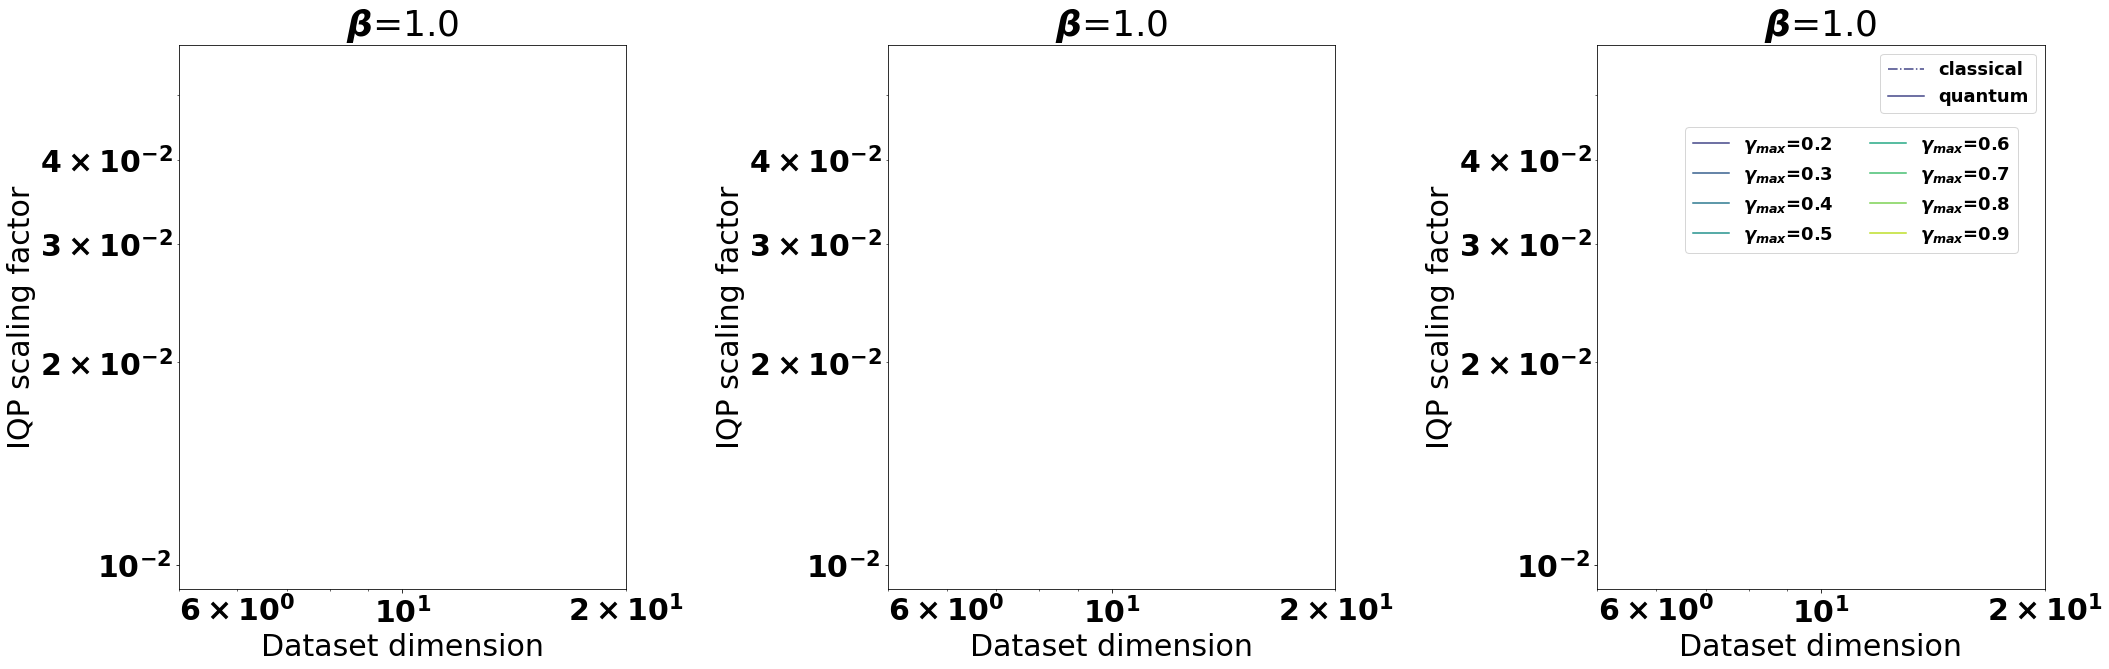

In [37]:
colormap=cm.viridis
gammas=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
test_sfs=set(hzz_df.scaling_factor)
beta=1.0

ndisfs=set(hzz_df.non_data_int_scaling_factor)

fig, axs = plt.subplots(1,len(ndisfs),figsize=(30,10))
for i,ndisf in enumerate(ndisfs):
    filter={'non_data_int_scaling_factor': ndisf}
    new_df=filter_df(hzz_df,filter)
    #new_df=compute_dataframe_kernel_eigenvalues(iqp_df,filter,k=3)

    ax=axs[i]
    quantum_df=new_df

    lines=[]
    handles=[]
    for gamma in gammas:
        test_sfs=list(set(quantum_df.scaling_factor))
        test_sfs.sort()
        q_curve=get_eigenvalue_scaling(quantum_df,gamma,test_sfs)
        label=r'$\gamma_{max}$='+str(gamma)
        color=colormap(gamma)
        line=ax.errorbar(q_curve[:,0],q_curve[:,1],label=label,color=color)

        lines.append(line[0])
        handles.append(label)

    ax.set_xlabel('Dataset dimension')
    ax.set_ylabel('IQP scaling factor')
    ax.set_xlim([5,20])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(r'$\beta$='+str(beta))

fig.legend(lines,handles,bbox_to_anchor=(0.95,0.8),fontsize=18,ncol=2)
lines=[
    Line2D([0,0],[0.1,1],ls='-.',color=colormap(0.2)),
    Line2D([0,0],[0.1,1],ls='-',color=colormap(0.2))
]
extra_legend = plt.legend(lines, ["classical","quantum"], loc=1,fontsize=18)
fig.tight_layout()
#fig.savefig(f'{save_folder}IQP_fixed_gamma_decay_curves_plots.png')